In [228]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [229]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 35% |


In [230]:
!nvidia-smi

Thu Nov  3 06:12:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   39C    P0    43W / 250W |  11239MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [208]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.model_selection import train_test_split

from align_faces import warp_and_crop_face, get_reference_facial_points

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm import tqdm
import random
import os
from torchmetrics import F1Score

import time

In [140]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [166]:
train_dir_path = '../input/data/train/'
train_image_path = '../input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')

def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))
dt_train

,id,gender,race,age,path,age_range
0,1,female,Asian,45,000001_female_Asian_45,1
1,2,female,Asian,52,000002_female_Asian_52,1
2,4,male,Asian,54,000004_male_Asian_54,1
3,5,female,Asian,58,000005_female_Asian_58,1
4,6,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
2695,6954,male,Asian,19,006954_male_Asian_19,0
2696,6955,male,Asian,19,006955_male_Asian_19,0
2697,6956,male,Asian,19,006956_male_Asian_19,0
2698,6957,male,Asian,20,006957_male_Asian_20,0


In [167]:
over_sixty = dt_train.loc[dt_train['age_range']==2,:]

In [168]:
over_sixty

,id,gender,race,age,path,age_range
31,39,female,Asian,60,000039_female_Asian_60,2
65,224,female,Asian,60,000224_female_Asian_60,2
70,229,male,Asian,60,000229_male_Asian_60,2
75,237,male,Asian,60,000237_male_Asian_60,2
94,267,male,Asian,60,000267_male_Asian_60,2
...,...,...,...,...,...,...
2168,5453,female,Asian,60,005453_female_Asian_60,2
2173,5459,male,Asian,60,005459_male_Asian_60,2
2175,5461,female,Asian,60,005461_female_Asian_60,2
2209,5504,female,Asian,60,005504_female_Asian_60,2


In [9]:
for idx in tqdm(range(len(over_sixty))):
    path = over_sixty.iloc[idx]['path']
    if os.path.exists(train_image_path+path+'_1') == False:
        os.mkdir(train_image_path+path+'_1')
    if os.path.exists(train_image_path+path+'_2') == False:
        os.mkdir(train_image_path+path+'_2')
        
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.' and i[-3:] != "npy"]:
        img = Image.open(train_image_path+path+'/'+file_name)
        img1 = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5)(img)
        img2 = torchvision.transforms.GaussianBlur(9, 4)(img)       
        img1.save(train_image_path+path+'_1'+'/'+file_name, 'JPEG')      
        img2.save(train_image_path+path+'_2'+'/'+file_name, 'JPEG')

100%|██████████| 209/209 [00:49<00:00,  4.19it/s]


In [169]:
path1 = []
path2 = []
for i in range(len(over_sixty)):
    path1.append(over_sixty.iloc[i]['path'] + '_1')
    path2.append(over_sixty.iloc[i]['path'] + '_2')

In [170]:
over_sixty_1 = pd.DataFrame({'id':over_sixty['id'] + "_1", 'gender':over_sixty['gender'], 'race':over_sixty['race'], 'age' : over_sixty['age'], 'path':path1, 'age_range':over_sixty['age_range']})
over_sixty_2 = pd.DataFrame({'id':over_sixty['id'] + "_2", 'gender':over_sixty['gender'], 'race':over_sixty['race'], 'age' : over_sixty['age'], 'path':path2, 'age_range':over_sixty['age_range']})

In [171]:
dt_train = dt_train.append(over_sixty_1, ignore_index=True)
dt_train = dt_train.append(over_sixty_2, ignore_index=True)
dt_train

,id,gender,race,age,path,age_range
0,1,female,Asian,45,000001_female_Asian_45,1
1,2,female,Asian,52,000002_female_Asian_52,1
2,4,male,Asian,54,000004_male_Asian_54,1
3,5,female,Asian,58,000005_female_Asian_58,1
4,6,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
3113,5453_2,female,Asian,60,005453_female_Asian_60_2,2
3114,5459_2,male,Asian,60,005459_male_Asian_60_2,2
3115,5461_2,female,Asian,60,005461_female_Asian_60_2,2
3116,5504_2,female,Asian,60,005504_female_Asian_60_2,2


In [172]:
dt_train.isnull().sum()

id           0
gender       0
race         0
age          0
path         0
age_range    0
dtype: int64

In [173]:
dt_train.to_csv('/opt/ml/input/data/train/aug_train.csv')

In [174]:
dt_train

,id,gender,race,age,path,age_range
0,1,female,Asian,45,000001_female_Asian_45,1
1,2,female,Asian,52,000002_female_Asian_52,1
2,4,male,Asian,54,000004_male_Asian_54,1
3,5,female,Asian,58,000005_female_Asian_58,1
4,6,female,Asian,59,000006_female_Asian_59,1
...,...,...,...,...,...,...
3113,5453_2,female,Asian,60,005453_female_Asian_60_2,2
3114,5459_2,male,Asian,60,005459_male_Asian_60_2,2
3115,5461_2,female,Asian,60,005461_female_Asian_60_2,2
3116,5504_2,female,Asian,60,005504_female_Asian_60_2,2


In [175]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])
dt_train.iloc[train_idx]

,id,gender,race,age,path,age_range
59,215,female,Asian,59,000215_female_Asian_59,1
1771,4217,female,Asian,60,004217_female_Asian_60,2
2091,5258,male,Asian,22,005258_male_Asian_22,0
25,31,female,Asian,54,000031_female_Asian_54,1
449,1069,female,Asian,19,001069_female_Asian_19,0
...,...,...,...,...,...,...
1117,3056,female,Asian,20,003056_female_Asian_20,0
1090,3023,female,Asian,20,003023_female_Asian_20,0
2988,3577_2,male,Asian,60,003577_male_Asian_60_2,2
2734,1482_1,female,Asian,60,001482_female_Asian_60_1,2


In [176]:
dt_train.iloc[valid_idx]

,id,gender,race,age,path,age_range
427,1047,male,Asian,60,001047_male_Asian_60,2
2871,4339_1,female,Asian,60,004339_female_Asian_60_1,2
1955,4486,male,Asian,20,004486_male_Asian_20,0
1084,3015,female,Asian,19,003015_female_Asian_19,0
689,1395,male,Asian,59,001395_male_Asian_59,1
...,...,...,...,...,...,...
2231,5529,female,Asian,44,005529_female_Asian_44,1
937,1724,female,Asian,22,001724_female_Asian_22,0
2528,6522,female,Asian,19,006522_female_Asian_19,0
2964,1598_2,female,Asian,60,001598_female_Asian_60_2,2


In [177]:
dt_train[dt_train['id'] == "1593"]

,id,gender,race,age,path,age_range
848,1593,female,Asian,60,001593_female_Asian_60,2


### aug_train.csv 로 preprocess.py 실행 

In [178]:
exp_train = pd.read_csv(train_dir_path+'aug_expanded_train.csv')

In [179]:
exp_train.drop(columns=['Unnamed: 0', 'Has_Face'], inplace=True)

In [180]:
exp_train

,PersonID,Path,Filename,Class,Mask,Gender,Age,Age_Class,BBoxX1,BBoxY1,BBoxX2,BBoxY2
0,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,110,146,250,347
1,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,112,160,245,334
2,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,107,127,230,311
3,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,120,143,244,326
4,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,10,1,1,45,1,122,125,244,316
...,...,...,...,...,...,...,...,...,...,...,...,...
21821,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,64,110,284,389
21822,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,66,102,293,397
21823,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,11,1,1,60,2,67,97,288,444
21824,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,17,2,1,60,2,77,120,273,410


In [117]:
# exp_train.drop(columns=['Unnamed: 0', 'Has_Face', 'Score', 'LE_X', 'LE_Y', 'RE_X', 'RE_Y', 'N_X', 'N_Y', 'LM_X', 'LM_Y', 'RM_X', 'RM_Y'], inplace=True)

In [181]:
def make_new_path(x):
    return x.split("images")[0] + 'new_images2' + x.split("images")[1]

In [182]:
exp_train['new_path'] = exp_train['Path'].apply(make_new_path)

In [183]:
exp_train

,PersonID,Path,Filename,Class,Mask,Gender,Age,Age_Class,BBoxX1,BBoxY1,BBoxX2,BBoxY2,new_path
0,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,110,146,250,347,../input/data/train/new_images2/000001_female_...
1,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,112,160,245,334,../input/data/train/new_images2/000001_female_...
2,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,107,127,230,311,../input/data/train/new_images2/000001_female_...
3,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,120,143,244,326,../input/data/train/new_images2/000001_female_...
4,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,10,1,1,45,1,122,125,244,316,../input/data/train/new_images2/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21821,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,64,110,284,389,../input/data/train/new_images2/005515_female_...
21822,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,66,102,293,397,../input/data/train/new_images2/005515_female_...
21823,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,11,1,1,60,2,67,97,288,444,../input/data/train/new_images2/005515_female_...
21824,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,17,2,1,60,2,77,120,273,410,../input/data/train/new_images2/005515_female_...


In [185]:
split_exp_train = exp_train[exp_train['PersonID'].isin(list(dt_train.iloc[train_idx]["id"]))]
split_exp_valid = exp_train[exp_train['PersonID'].isin(list(dt_train.iloc[valid_idx]["id"]))]

print(f"index size: {len(train_idx)} == file estimate: {len(train_idx) * 7} == split size: {len(split_exp_train)}")
split_exp_train

index size: 2494 == file estimate: 17458 == split size: 17430


,PersonID,Path,Filename,Class,Mask,Gender,Age,Age_Class,BBoxX1,BBoxY1,BBoxX2,BBoxY2,new_path
0,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,110,146,250,347,../input/data/train/new_images2/000001_female_...
1,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,112,160,245,334,../input/data/train/new_images2/000001_female_...
2,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,107,127,230,311,../input/data/train/new_images2/000001_female_...
3,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,120,143,244,326,../input/data/train/new_images2/000001_female_...
4,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,10,1,1,45,1,122,125,244,316,../input/data/train/new_images2/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21821,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,64,110,284,389,../input/data/train/new_images2/005515_female_...
21822,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,66,102,293,397,../input/data/train/new_images2/005515_female_...
21823,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,11,1,1,60,2,67,97,288,444,../input/data/train/new_images2/005515_female_...
21824,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,17,2,1,60,2,77,120,273,410,../input/data/train/new_images2/005515_female_...


In [186]:
split_exp_valid

,PersonID,Path,Filename,Class,Mask,Gender,Age,Age_Class,BBoxX1,BBoxY1,BBoxX2,BBoxY2,new_path
7,2,../input/data/train/images/000002_female_Asian...,../input/data/train/images/000002_female_Asian...,4,0,1,52,1,103,146,252,334,../input/data/train/new_images2/000002_female_...
8,2,../input/data/train/images/000002_female_Asian...,../input/data/train/images/000002_female_Asian...,4,0,1,52,1,104,167,241,347,../input/data/train/new_images2/000002_female_...
9,2,../input/data/train/images/000002_female_Asian...,../input/data/train/images/000002_female_Asian...,4,0,1,52,1,108,181,254,371,../input/data/train/new_images2/000002_female_...
10,2,../input/data/train/images/000002_female_Asian...,../input/data/train/images/000002_female_Asian...,4,0,1,52,1,103,172,244,353,../input/data/train/new_images2/000002_female_...
11,2,../input/data/train/images/000002_female_Asian...,../input/data/train/images/000002_female_Asian...,10,1,1,52,1,112,170,253,365,../input/data/train/new_images2/000002_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21814,5504,../input/data/train/images/005504_female_Asian...,../input/data/train/images/005504_female_Asian...,5,0,1,60,2,98,134,271,369,../input/data/train/new_images2/005504_female_...
21815,5504,../input/data/train/images/005504_female_Asian...,../input/data/train/images/005504_female_Asian...,5,0,1,60,2,81,144,257,380,../input/data/train/new_images2/005504_female_...
21816,5504,../input/data/train/images/005504_female_Asian...,../input/data/train/images/005504_female_Asian...,11,1,1,60,2,88,128,266,379,../input/data/train/new_images2/005504_female_...
21817,5504,../input/data/train/images/005504_female_Asian...,../input/data/train/images/005504_female_Asian...,17,2,1,60,2,95,134,277,399,../input/data/train/new_images2/005504_female_...


In [189]:
for idx in range(len(exp_train)):
    filename = exp_train.iloc[idx]['Path']
    new_filename = exp_train.iloc[idx]['new_path']
    parent_dir = '/'.join(new_filename.split("/")[:-1])

In [194]:
exp_train

,PersonID,Path,Filename,Class,Mask,Gender,Age,Age_Class,BBoxX1,BBoxY1,BBoxX2,BBoxY2,new_path
0,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,110,146,250,347,../input/data/train/new_images2/000001_female_...
1,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,112,160,245,334,../input/data/train/new_images2/000001_female_...
2,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,107,127,230,311,../input/data/train/new_images2/000001_female_...
3,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,4,0,1,45,1,120,143,244,326,../input/data/train/new_images2/000001_female_...
4,1,../input/data/train/images/000001_female_Asian...,../input/data/train/images/000001_female_Asian...,10,1,1,45,1,122,125,244,316,../input/data/train/new_images2/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21821,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,64,110,284,389,../input/data/train/new_images2/005515_female_...
21822,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,5,0,1,60,2,66,102,293,397,../input/data/train/new_images2/005515_female_...
21823,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,11,1,1,60,2,67,97,288,444,../input/data/train/new_images2/005515_female_...
21824,5515,../input/data/train/images/005515_female_Asian...,../input/data/train/images/005515_female_Asian...,17,2,1,60,2,77,120,273,410,../input/data/train/new_images2/005515_female_...


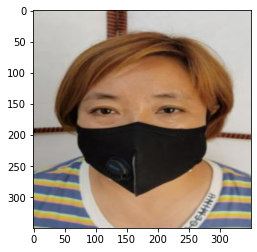

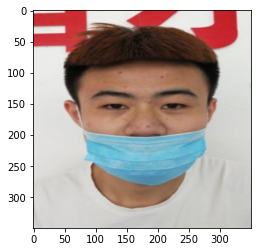

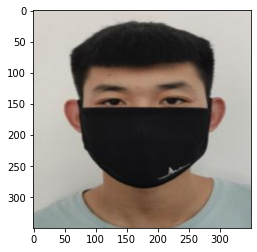

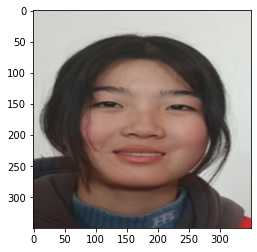

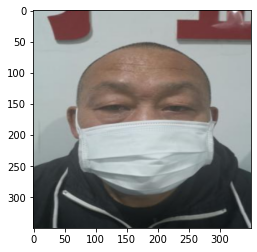

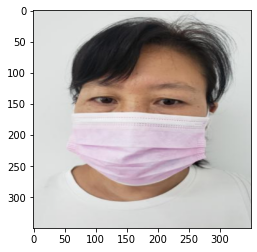

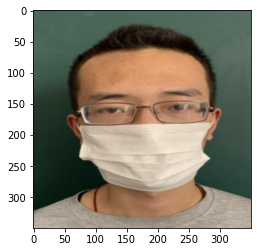

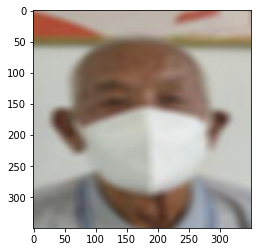

In [195]:
for idx in range(len(exp_train)):
    filename = exp_train.iloc[idx]['Path']
    new_filename = exp_train.iloc[idx]['new_path']
    parent_dir = '/'.join(new_filename.split("/")[:-1])
    
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    
    X = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    x1 = exp_train.iloc[idx]['BBoxX1']
    x2 = exp_train.iloc[idx]['BBoxX2']
    y1 = exp_train.iloc[idx]['BBoxY1']
    y2 = exp_train.iloc[idx]['BBoxY2']
    w = x2 - x1
    h = y2 - y1
    w = w // 3
    h = h // 3

    nx1 = max(0, x1-w)
    nx2 = min(384, x2+w)
    ny1 = max(0, y1-h)
    ny2 = min(512, y2+h)
    X = X[ny1:ny2, nx1:nx2]
    
    
    X = cv2.resize(X, (350, 350))
    if idx % 3000 == 0:
        plt.imshow(X)
        plt.show()
        
    X = cv2.cvtColor(X, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(new_filename, X)

In [196]:
train_image = split_exp_train.loc[:,"new_path"]
train_label = split_exp_train.loc[:,"Class"]

valid_image = split_exp_valid.loc[:,"new_path"]
valid_label = split_exp_valid.loc[:,"Class"]

In [197]:
print(len(train_image))
print(len(valid_image))

17430
4396


In [198]:
train_data = pd.Series(train_image)
train_label = pd.Series(train_label)

valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [199]:
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, CenterCrop, ColorJitter
from PIL import Image

class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None, is_train=True):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data.reset_index(drop=True)
        self.is_train = is_train
        self.label = label.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.transform:
            return self.transform(X), y

        return X, y

In [200]:
mask_train_set = Dataset_Mask(data=train_data, label=train_label, is_train=True, transform=transforms.Compose([
                                    ToTensor(),
                            ]))

In [201]:
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, is_train=False, transform = transforms.Compose([
                                    ToTensor(),
                            ]))

In [204]:
def make_class_weights(labels, class_num):
    print(labels.shape)
    print(labels)

    labels = np.array(labels)
    class_weights = np.zeros_like(labels) 
    
    _, counts = np.unique(labels, return_counts=True)
    # 각 class가 몇 번 등장하는지 count

    print(labels)
    print(counts)

    for cls in range(class_num):
        class_weights = np.where(labels == cls, 1/counts[cls], class_weights)
        # label이 class에 해당하면 count의 역수 적용
    return class_weights
class_num = 18

In [205]:
class_weights = make_class_weights(mask_train_set.label, class_num) # np to double tensor

print(class_weights)
print(len(class_weights))

(17430,)
0         4
1         4
2         4
3         4
4        10
         ..
17425     5
17426     5
17427    11
17428    17
17429     5
Name: Class, Length: 17430, dtype: int64
[ 4  4  4 ... 11 17  5]
[2265 1586 1140 2860 3251 1350  453  316  228  572  649  270  453  317
  228  572  650  270]
[0.0003076  0.0003076  0.0003076  ... 0.0037037  0.0037037  0.00074074]
17430


In [209]:
sampler = sampler.WeightedRandomSampler(weights=class_weights, num_samples=len(class_weights))

In [210]:
t_image = [mask_train_set[i][1] for i in range(len(mask_train_set))]
v_image = [mask_val_set[i][1] for i in range(len(mask_val_set))]

In [211]:
t_df = pd.DataFrame(t_image, columns=['counts'])
v_df = pd.DataFrame(v_image, columns=['counts'])

Text(0.5, 0, 'valid set labels')

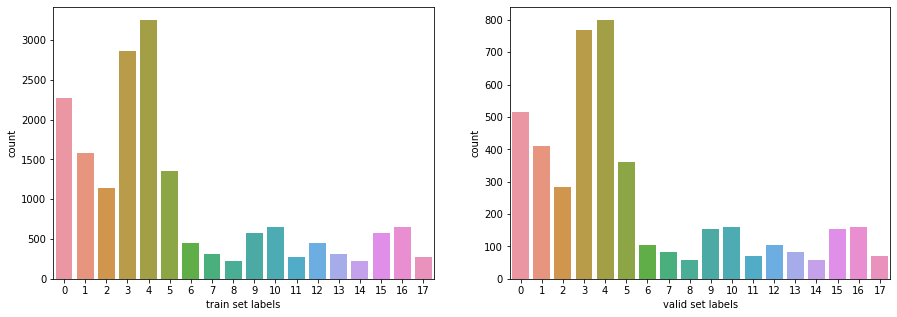

In [212]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='counts', data=t_df, ax=axes[0])
axes[0].set_xlabel("train set labels")
sns.countplot(x='counts', data=v_df, ax=axes[1])
axes[1].set_xlabel("valid set labels")

In [213]:
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 17430
validation data size : 4396


In [214]:
batch_size = 64

train_dataloader_mask = DataLoader(dataset = mask_train_set, batch_size=batch_size, sampler=sampler, num_workers=2)
val_dataloader_mask = DataLoader(dataset = mask_val_set, batch_size=batch_size, num_workers=2)

In [215]:
model = torchvision.models.resnet50(pretrained=True)
# print('필요 입력 채널 개수', model.conv1.weight.shape[1])
# print('네트워크 출력 채널 개수', model.fc.weight.shape[0])
# print(model)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [216]:
import math
class_num = 18
model.fc = nn.Linear(in_features=2048, out_features=class_num, bias=True)
nn.init.xavier_uniform_(model.fc.weight)
stdv = 1. / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

print('필요 입력 채널 개수', model.conv1.weight.shape[1])
print('네트워크 출력 채널 개수', model.fc.weight.shape[0])

필요 입력 채널 개수 3
네트워크 출력 채널 개수 18


In [217]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

model = torch.nn.DataParallel(model)
model.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#lr = 1e-3
#betas = (0.9, 0.999)
#weight_decay = 0.5e-4
#eps = 1e-8
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay, eps=eps)

using cuda:0


In [218]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(model.named_parameters()):
    if param.requires_grad:
        
        #if param_name.startswith('module.fc') or param_name.startswith('module.layer4') or param_name.startswith('module.layer3'):
        #    param.requires_grad = True  # Train
        #else:
        #    param.requires_grad = False # Freeze
            
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
#         print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
#         print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
#         print(f"    --[{param.requires_grad}].")
# print ("Total number of parameters:[%s]."%(format(n_param,',d')))

In [231]:
best_val_acc = 0
best_val_loss = np.inf
patience = 10
cur_count = 0

f1 = F1Score(num_classes=class_num, average='macro').to(device)
best_f1_score = 0

for epoch in range(NUM_EPOCH):
    model.train()
    loss_value = 0
    matches = 0
    for train_batch in tqdm(train_dataloader_mask):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        torch.save(model, '../checkpoint/resnet50_crop_agu_detection/checkpoint_ep_%d.pth'% epoch)
        
        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        
    train_loss = loss_value / len(train_dataloader_mask)
    train_acc = matches / len(mask_train_set)
    
    print(f"epoch[{epoch}/{NUM_EPOCH}] training loss {train_loss:.3f}, training accuracy {train_acc:.3f}")
    
    with torch.no_grad():
        model.eval()
        val_loss_items = []
        val_acc_items = []
        f1_score = 0
        
        for val_batch in tqdm(val_dataloader_mask):
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)
            
            loss_item = criterion(outs, labels).item()
            acc_item = (labels==preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)
            f1_score += f1(outs, labels)
            
        val_loss = np.sum(val_loss_items) / len(val_dataloader_mask)
        val_acc = np.sum(val_acc_items) / len(mask_val_set)

        f1_score /= len(val_dataloader_mask)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            cur_count = 0
            torch.save(model, '../checkpoint/resnet50_crop_agu_detection/checkpoint_best.pth')
            print("Update checkpoint!!!")
        
        else:
            cur_count += 1
            if cur_count >= patience:
                print("Early Stopping!")
                break

            
        print(f"[val] acc : {val_acc:.3f}, loss : {val_loss:.3f}, f1 score: {f1_score:.3f} -- size({len(val_dataloader_mask)})")
        print(f"best acc : {best_val_acc:.3f}, best loss : {best_val_loss:.3f}, best f1 : {best_f1_score:.3f}")

  0%|          | 0/69 [00:00<?, ?it/s]

epoch[0/50] training loss 0.281, training accuracy 0.915


  0%|          | 0/273 [00:00<?, ?it/s]

Update checkpoint!!!
[val] acc : 0.834, loss : 0.590, f1 score: 0.673 -- size(69)
best acc : 0.834, best loss : 0.590, best f1 : 0.673


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[1/50] training loss 0.045, training accuracy 0.988


  0%|          | 0/273 [00:00<?, ?it/s]

Update checkpoint!!!
[val] acc : 0.860, loss : 0.604, f1 score: 0.734 -- size(69)
best acc : 0.860, best loss : 0.590, best f1 : 0.734


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[2/50] training loss 0.027, training accuracy 0.992


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.848, loss : 0.650, f1 score: 0.717 -- size(69)
best acc : 0.860, best loss : 0.590, best f1 : 0.734


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[3/50] training loss 0.019, training accuracy 0.995


  0%|          | 0/273 [00:00<?, ?it/s]

Update checkpoint!!!
[val] acc : 0.881, loss : 0.602, f1 score: 0.768 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[4/50] training loss 0.018, training accuracy 0.994


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.861, loss : 0.622, f1 score: 0.727 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[5/50] training loss 0.015, training accuracy 0.995


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.863, loss : 0.693, f1 score: 0.748 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[6/50] training loss 0.018, training accuracy 0.994


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.864, loss : 0.697, f1 score: 0.741 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[7/50] training loss 0.013, training accuracy 0.996


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.873, loss : 0.695, f1 score: 0.756 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[8/50] training loss 0.013, training accuracy 0.996


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.846, loss : 0.821, f1 score: 0.672 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[9/50] training loss 0.016, training accuracy 0.996


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.876, loss : 0.655, f1 score: 0.756 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[10/50] training loss 0.013, training accuracy 0.996


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.854, loss : 0.752, f1 score: 0.721 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[11/50] training loss 0.005, training accuracy 0.999


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.858, loss : 0.782, f1 score: 0.723 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[12/50] training loss 0.013, training accuracy 0.996


  0%|          | 0/273 [00:00<?, ?it/s]

[val] acc : 0.872, loss : 0.773, f1 score: 0.743 -- size(69)
best acc : 0.881, best loss : 0.590, best f1 : 0.768


  0%|          | 0/69 [00:00<?, ?it/s]

epoch[13/50] training loss 0.004, training accuracy 0.999


100%|██████████| 69/69 [00:14<00:00,  4.87it/s]

Early Stopping!


In [233]:
print(f"best acc : {best_val_acc:.3f}, best loss : {best_val_loss:.3f}, best f1 : {best_f1_score:.3f}")

best acc : 0.881, best loss : 0.590, best f1 : 0.768


In [234]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir_path = '/opt/ml/input/data/eval/'
test_image_path = '/opt/ml/input/data/new_images2/'

model = torch.load('/opt/ml/checkpoint/resnet50_crop_agu_detection/checkpoint_best.pth')
submission = pd.read_csv(test_dir_path+'info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [235]:
image_paths = [os.path.join(test_image_path, img_id) for img_id in submission.ImageID]
test_image = pd.Series(image_paths)

In [236]:
image_paths[0]

'/opt/ml/input/data/new_images2/cbc5c6e168e63498590db46022617123f1fe1268.jpg'

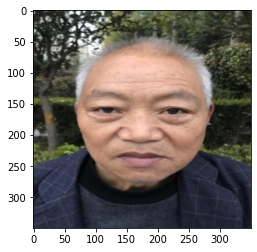

In [237]:
plt.imshow(plt.imread(image_paths[0]))

In [238]:
class Test_Dataset(Dataset):
    def __init__(self, midcrop=True, transform=None):
        self.midcrop = midcrop
        self.data = test_image
        self.transform = transform
        
    def __len__(self):
        return len(test_image)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
            
        if self.transform:
            img = self.transform(img)
            
        return img

In [239]:
batch_size = 64

In [240]:
dataset = Test_Dataset(transform = transforms.Compose([
                            transforms.ToTensor()
                        ]))

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:

    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir_path, 'submission_detection_crop3.csv'), index=False)
print('test inference is done!')

test inference is done!
